In [1]:
import jax.numpy as jnp
import jax.random as jrandom

import matplotlib.pyplot as plt
import pandas as pd
from jax import jit, grad, jacfwd, jacrev

from scipy.stats import linregress

from tqdm import tqdm
import pickle

import numpy as np

from save_load import *

from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

import itertools

import os, shutil
HOME = os.getenv("HOME")

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,12]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})

In [2]:
def convert_file_name(opt_type, file_name):
    file_name_split = file_name.split("_")
    
    res = {}
    
    if opt_type in ["GradientDescent", "NewtonsMethod"]:
        common_args = ["step_size"] 
    else:
        common_args = ["step_size", "noise_type", "sig"] 

    
    for i in range(len(common_args)):
        res[common_args[i]] = file_name_split[i]
        
    i = len(common_args)
    while i < len(file_name_split):
        if file_name_split[i] == "max":
            res["max_h"] = file_name_split[i + 2]
            i += 3
        else:
            res[file_name_split[i]] = file_name_split[i + 1]
            i += 2

    return res
    


def load_df():
    res_dir_path = HOME + "/curr_adventure/exact_sampling/OptimizationResults/"
    
    res_dict = {}
    
    for opt_type in os.listdir(res_dir_path):
        if opt_type == ".DS_Store":
            continue
            
        for F_name in os.listdir(res_dir_path + opt_type):
            if (F_name, opt_type) not in res_dict:
                res_dict[(F_name, opt_type)] = []
        
            for file_name in os.listdir(res_dir_path + opt_type + "/" + F_name):
                
                if os.path.isdir(res_dir_path + opt_type + "/" + F_name + "/" + file_name):
                    curr_d = convert_file_name(opt_type, file_name)
                    res_dict[(F_name, opt_type)].append(curr_d)
                    
    pd_res_dict = {}
        
    for k, v in res_dict.items():
        pd_res_dict[k] = pd.DataFrame(v)
    
    return pd.concat(pd_res_dict).sort_index()
        
    

In [3]:
def series_average(ys, xs):
    xs_new = jnp.sort(jnp.unique(jnp.concatenate(xs)))

    ys_interp = jnp.array([jnp.interp(xs_new, xs[i], ys[i]) for i in range(len(ys))])
                 
                 
    ys_mean = jnp.mean(ys_interp, axis=0)
    ys_std = jnp.std(ys_interp, axis=0)
    return xs_new, ys_mean, ys_std
    

In [4]:
def load_opt(opt_type, test_problem_name, sig, noise_type, step_size, seed, additional_info={}):
    load_dir_path = HOME + "/curr_adventure/exact_sampling/OptimizationResults/{}/{}/".format(opt_type, test_problem_name)
    
    if opt_type in ["GradientDescent", "NewtonsMethod"]:
        load_name = "{}".format(step_size)
    else:
        load_name = "{}_{}_{}".format(step_size, noise_type, sig)
        
        if additional_info is not None:
            for k in additional_info:
                load_name += "_{}_{}".format(k, additional_info[k])
        
    load_name = load_dir_path + load_name + "/seed_{}".format(seed)
    
    if not os.path.exists(load_name):
        return None, None
    
    with open(load_name + "/vals.pkl", "rb") as f:
        d_res = pickle.load(f)
        
    with open(load_name + "/x_data.pkl", "rb") as f:
        d_x_data = pickle.load(f)
        
    return d_res, d_x_data

In [5]:
def load_all_opt(opt_type, test_problem_name, sig, noise_type, step_size, additional_info={}):
    load_dir_path = HOME + "/curr_adventure/exact_sampling/OptimizationResults/{}/{}/".format(opt_type, test_problem_name)
    
    if opt_type in ["GradientDescent", "NewtonsMethod"]:
        return load_opt(opt_type, test_problem_name, sig, noise_type, step_size, seed="None", additional_info={})
    
    load_name = "{}_{}_{}".format(float(step_size), noise_type, float(sig))
    
    if additional_info is not None:
        for k in additional_info:
            load_name += "_{}_{}".format(k, additional_info[k])

    load_name = load_dir_path + load_name + "/all"

    if os.path.exists(load_name):
        with open(load_name + "/all_vals.pkl", "rb") as f:
            d_res = pickle.load(f)
        
        with open(load_name + "/all_x_data.pkl", "rb") as f:
            d_x_data = pickle.load(f)
    else:
        return None, None
    
    return d_res, d_x_data



In [6]:
df = load_df()

In [7]:
# Iteration averaged plots. We have to specify HP for each opt type

df2 = df.reset_index().drop(columns=["level_0", "level_2"])
df2.drop_duplicates()

,level_1,step_size,noise_type,sig,h
0,AdaptFD_GD,1e-06,uniform,20.0,NaN
1,AdaptFD_GD,1e-06,uniform,10.0,NaN
2,CFD_GD,1e-06,uniform,10.0,1.0
3,CFD_GD,1e-05,uniform,1.0,1.0
4,CFD_GD,1e-05,uniform,1.0,0.5
5,CFD_GD,1e-05,uniform,20.0,0.1
6,CFD_GD,1e-06,uniform,20.0,0.5
7,CFD_GD,1e-05,uniform,20.0,1.0
8,CFD_GD,1e-06,uniform,20.0,0.1
9,CFD_GD,1e-06,uniform,20.0,1.0


In [8]:
hp = {
    "sig": 20,
    "noise_type": "uniform",
    "step_size": 1e-5
}

# hp_s = {
#     "OurMethod_GD": {"coeff": 0, "max_h": [0.5, 2]},
#     "FD_GD": {"h": 0.1},
#     "CentralFD_GD": {"h": 0.5}
# }

In [9]:
# Get min 
res = {}

hp_s_mult = {
    "OurMethod_GD": {"h": [0.1, 0.5, 1.0]},
    "FD_GD": {"h": [0.1, 0.5, 1.0]},
    "CFD_GD": {"h": [0.1, 0.5, 1.0]}
}


def get_min(opt_type, F_name, hp, add_info):
    xs = [] 
    ys = []
    
    if opt_type in ["GradientDescent", "NewtonsMethod"]:
        opt_res, _ = load_opt(opt_type, F_name, hp["sig"], hp["noise_type"], hp["step_size"], seed=None, additional_info=add_info)
        opt_res_all = {"0": opt_res}
    else:
        opt_res_all, _ = load_all_opt(opt_type, F_name, hp["sig"], hp["noise_type"], hp["step_size"], additional_info=add_info)
        
    if opt_res_all is None:
        print(F_name)
        print(hp)
        print(opt_type)
        print(add_info)
        return float('inf')
        
    for opt_res in opt_res_all.values():
        if len(opt_res.shape) == 1:
            ys.append(opt_res)
        else:
            ys.append(opt_res[:, 0])
        xs.append(jnp.array(range(len(opt_res))))
            
    if len(xs) == 0:
        return float('inf')

        
    xs_new, ys_mean, ys_std = series_average(ys, xs)

    
    return jnp.min(ys_mean)
    

for F_name in tqdm(df.index.unique(0)):
    for opt_type in df.index.levels[1]:
        if opt_type in ["AdaptFD_GD", "NEWUOA", "GradientDescent", "NewtonsMethod"]:
            continue
        if opt_type not in res:
            res[opt_type] = []
        if opt_type not in df.loc[F_name].index.unique(0):
            res[opt_type].append(float("inf"))
            continue
            
        curr_min = float("inf")
            
        if opt_type in hp_s_mult:
            for curr_hp in itertools.product(*hp_s_mult[opt_type].values()):
                curr_hp_s = {list(hp_s_mult[opt_type].keys())[i]: curr_hp[i] for i in range(len(curr_hp))}

                add_info = curr_hp_s
                curr_min = min(curr_min, get_min(opt_type, F_name, hp, add_info))
        else:
            add_info = {}
            curr_min = get_min(opt_type, F_name, hp, add_info)
        


            
        res[opt_type].append(curr_min)


            


100%|██████████| 145/145 [04:10<00:00,  1.73s/it]


In [10]:
def get_confusion_matrix(res_dict):
    
    res_m = []
    
    for k1 in res_dict.keys():
        res_m.append([])
        for k2 in res_dict.keys():
            score = jnp.sum((jnp.array(res_dict[k1]) < jnp.array(res_dict[k2]))) - (len(res_dict[k1]) - jnp.sum((jnp.array(res_dict[k1]) == jnp.array(res_dict[k2]))))/2.
            res_m[-1].append(float(score))
            
    
    return list(res_dict.keys()), res_m


    

<BarContainer object of 145 artists>

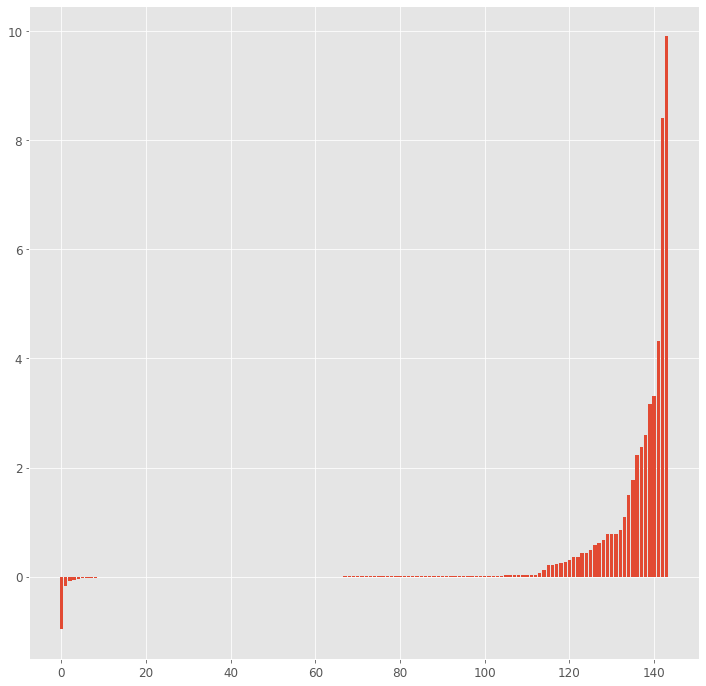

In [11]:
k1 = "OurMethod_GD"
k2 = "CFD_GD"
per_prof = jnp.log(jnp.array(res[k1])/jnp.array(res[k2])) / jnp.log(2) # if k1 better (lower) then negative. 
plt.bar(range(len(per_prof)), jnp.sort(per_prof))

<AxesSubplot:>

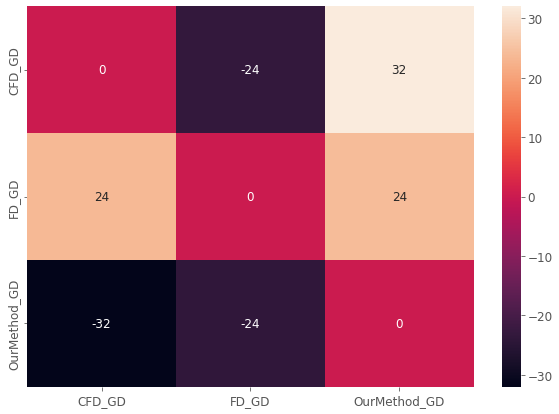

In [12]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels, mat = get_confusion_matrix(res)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)



  0%|          | 0/145 [00:00<?, ?it/s]

AIRCRFTB_5


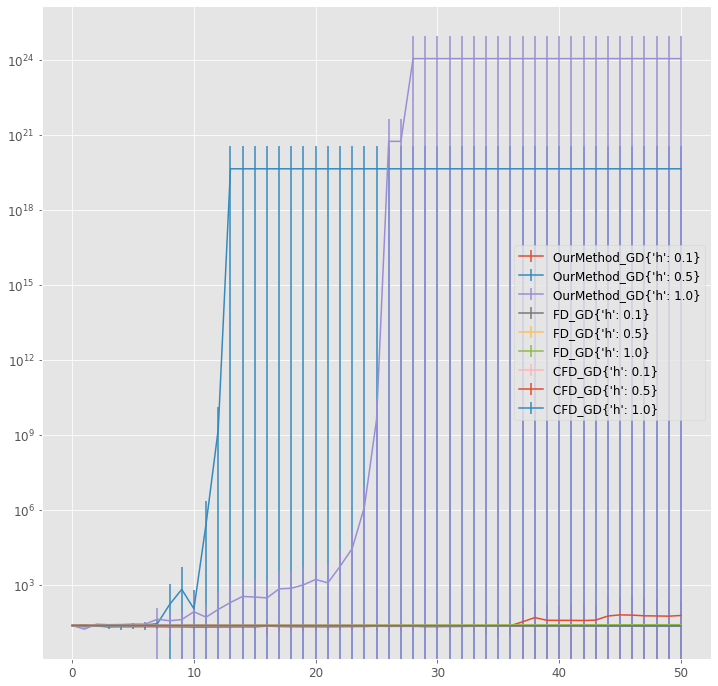

  1%|          | 1/145 [00:02<07:08,  2.97s/it]

ALLINITU_4


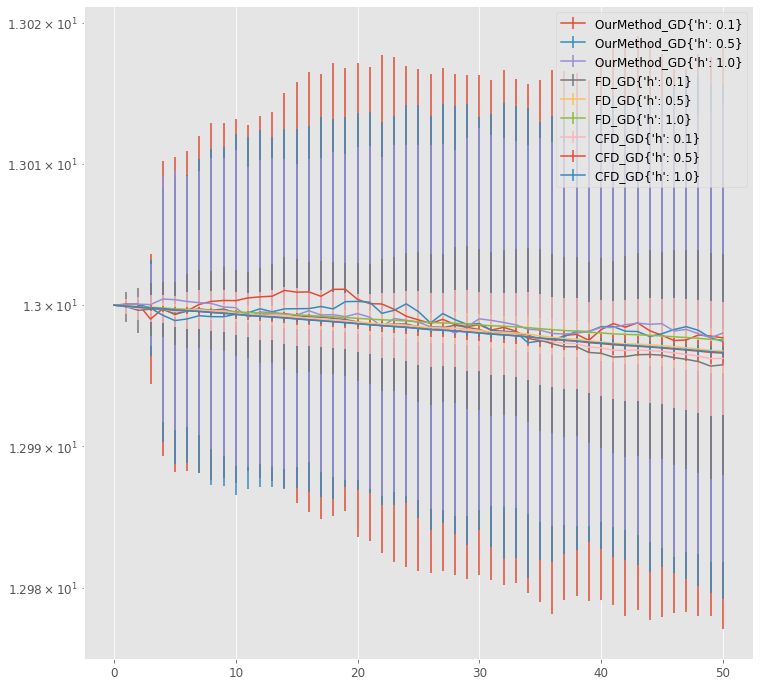

  1%|▏         | 2/145 [00:04<04:27,  1.87s/it]

ARWHEAD_100


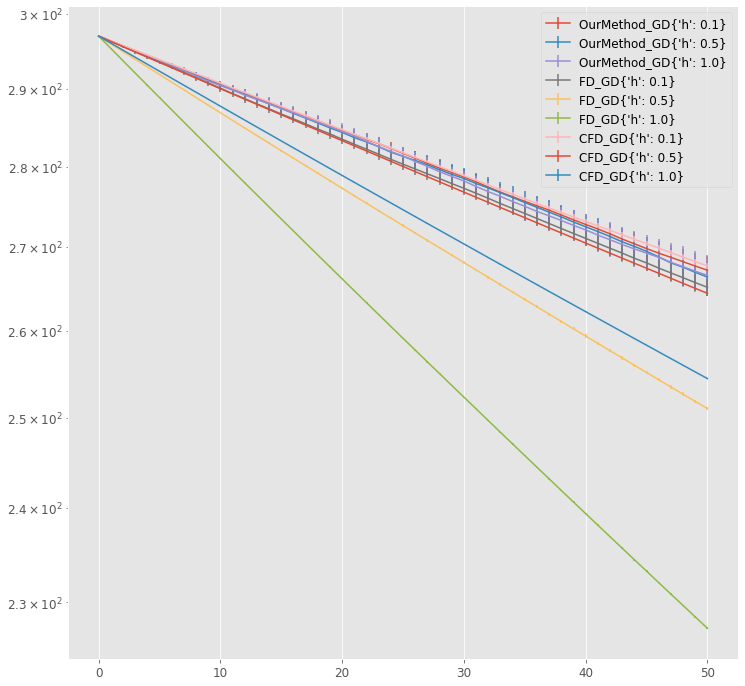

  2%|▏         | 3/145 [00:05<04:00,  1.69s/it]

BARD_3


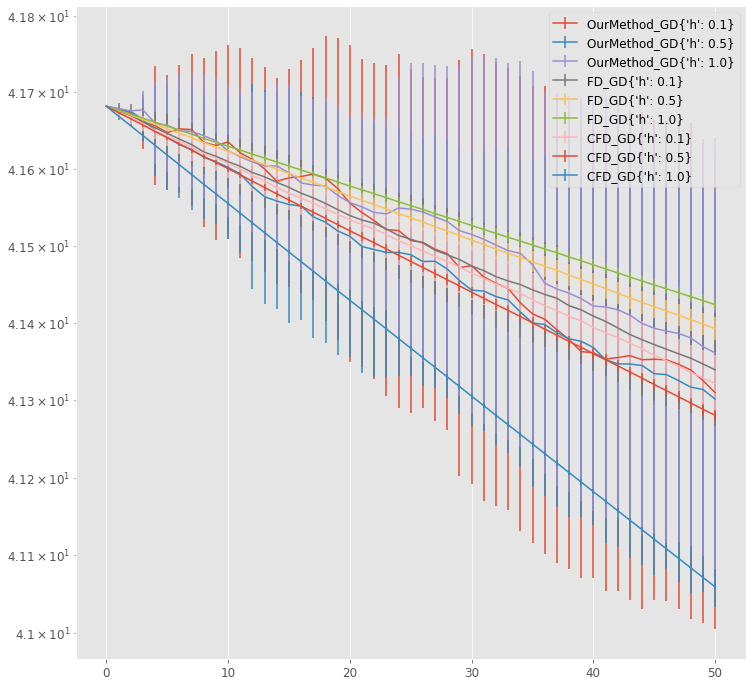

  3%|▎         | 4/145 [00:06<03:32,  1.50s/it]

BDQRTIC_100


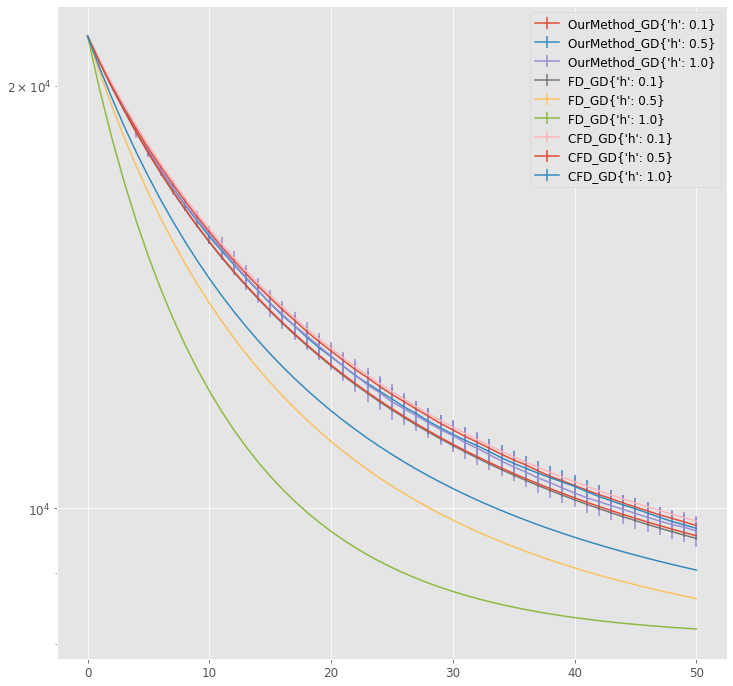

  3%|▎         | 5/145 [00:08<03:26,  1.47s/it]

BIGGS3_3


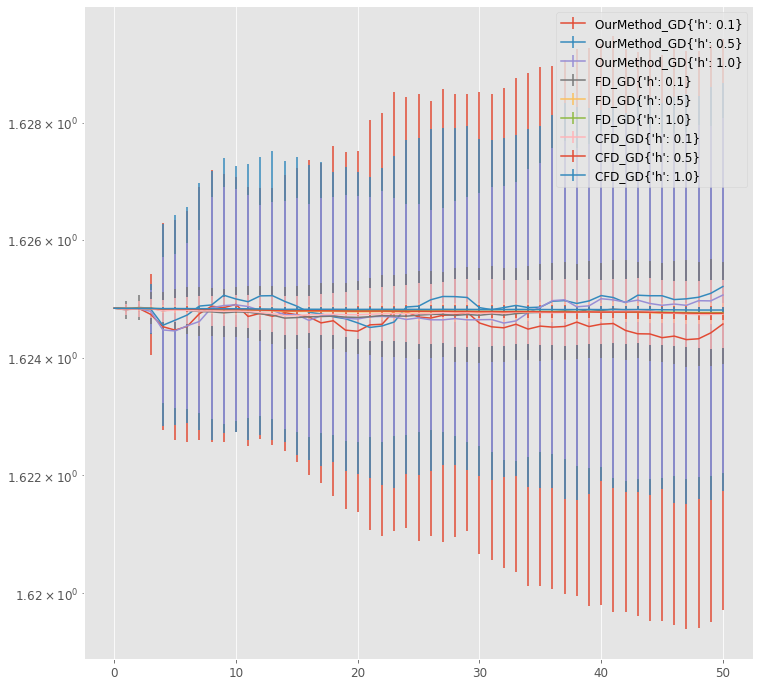

  4%|▍         | 6/145 [00:09<03:12,  1.39s/it]

BIGGS5_5


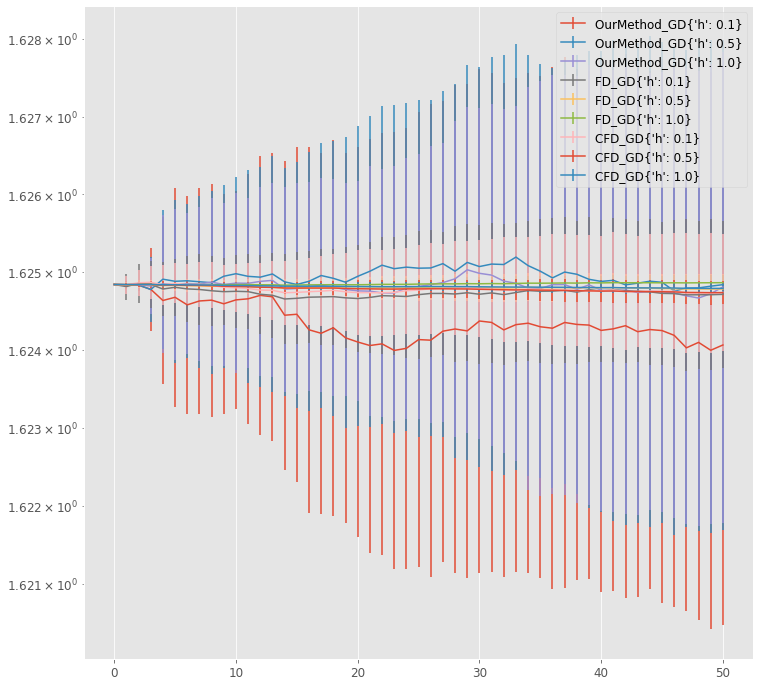

  5%|▍         | 7/145 [00:10<03:11,  1.39s/it]

BIGGS6_6


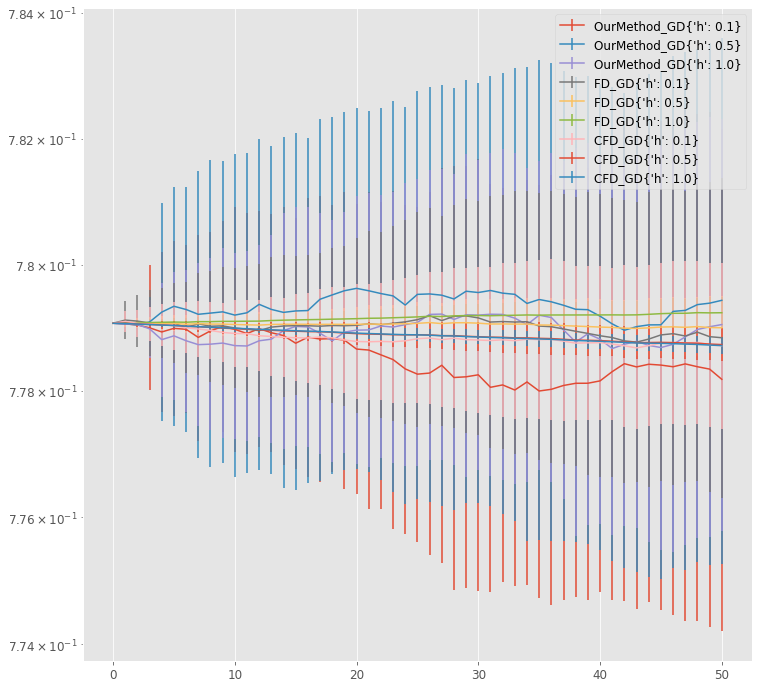

  6%|▌         | 8/145 [00:11<03:00,  1.32s/it]

BOX2_2


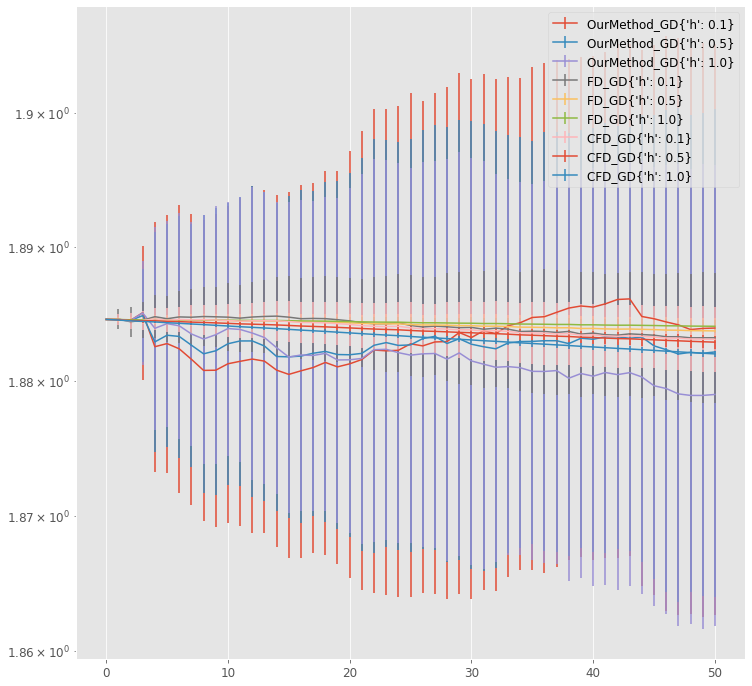

  6%|▌         | 9/145 [00:13<02:51,  1.26s/it]

BOX3_3


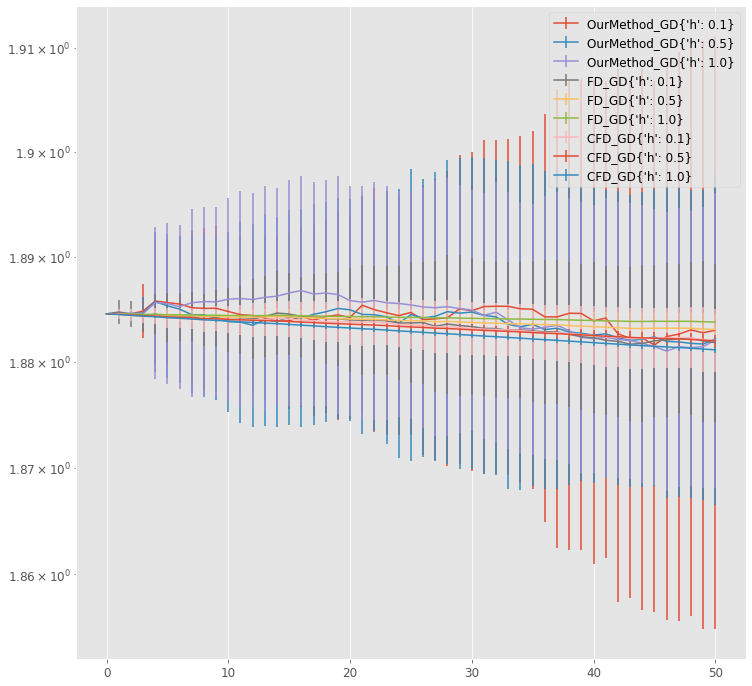

  7%|▋         | 10/145 [00:14<02:44,  1.22s/it]

BRKMCC_2


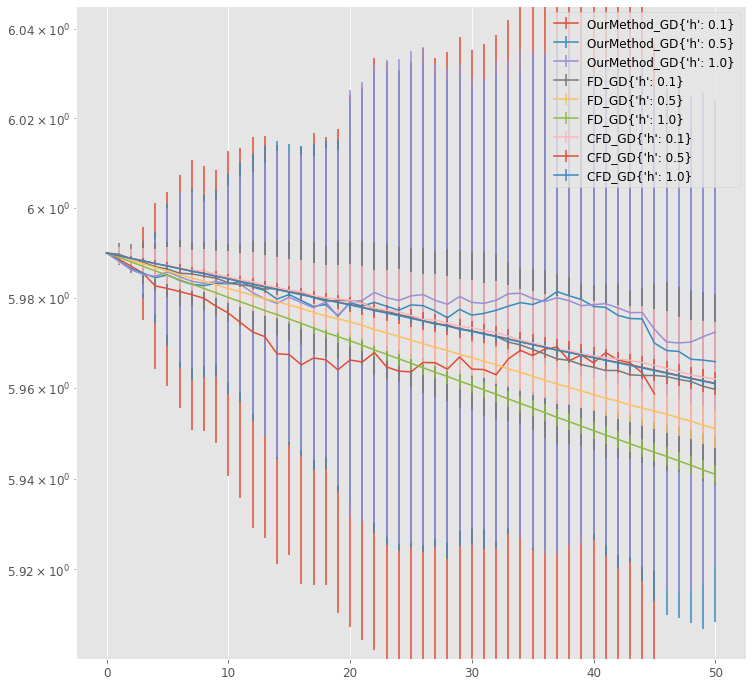

  8%|▊         | 11/145 [00:15<02:44,  1.22s/it]

BROWNAL_10


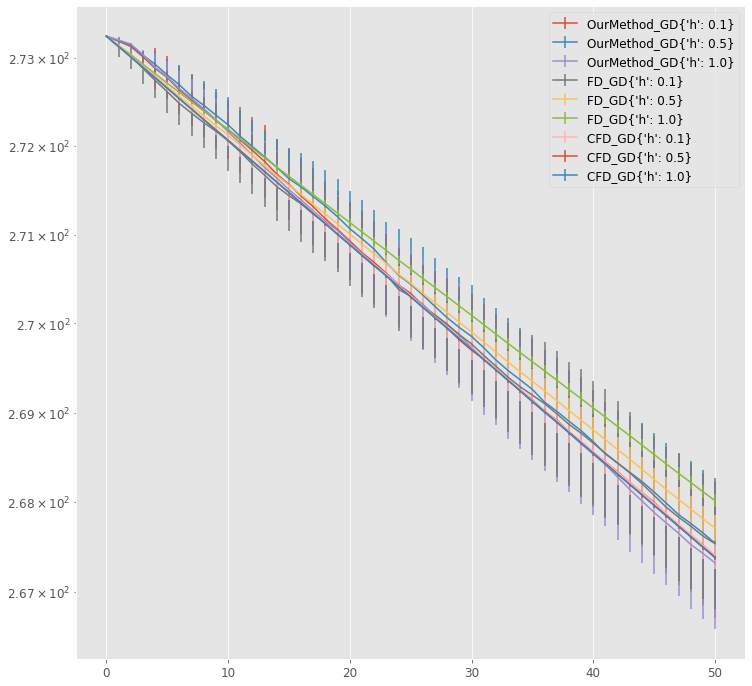

  8%|▊         | 12/145 [00:16<02:48,  1.27s/it]

BROWNAL_100


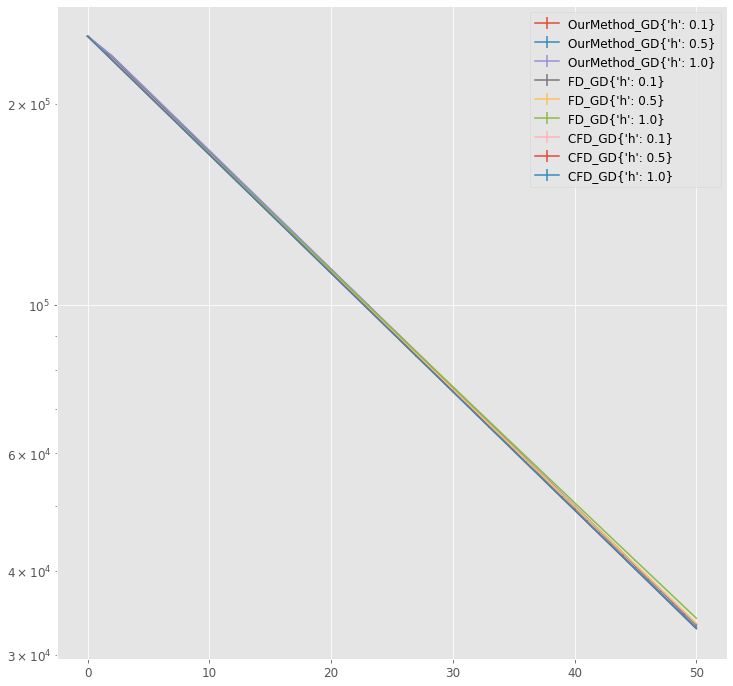

  9%|▉         | 13/145 [00:18<03:04,  1.40s/it]

BROWNAL_200


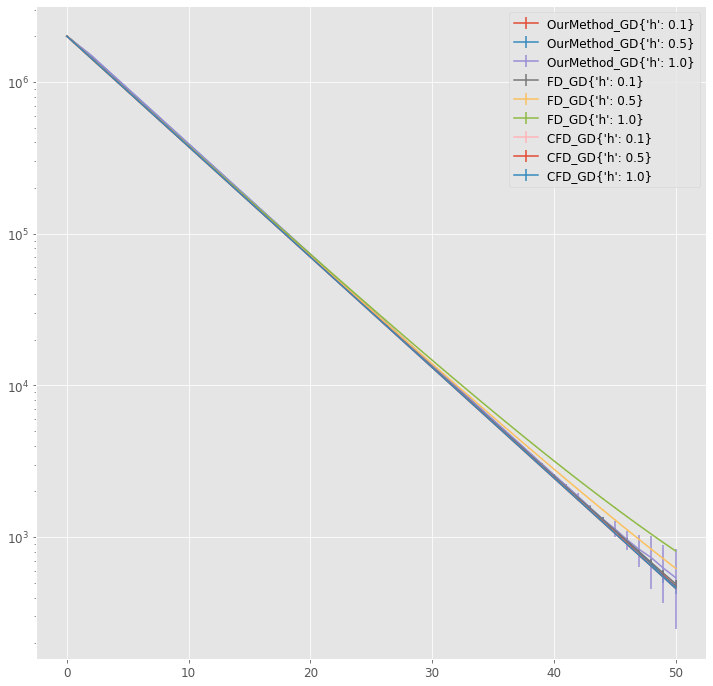

 10%|▉         | 14/145 [00:20<03:18,  1.52s/it]

BROWNDEN_4


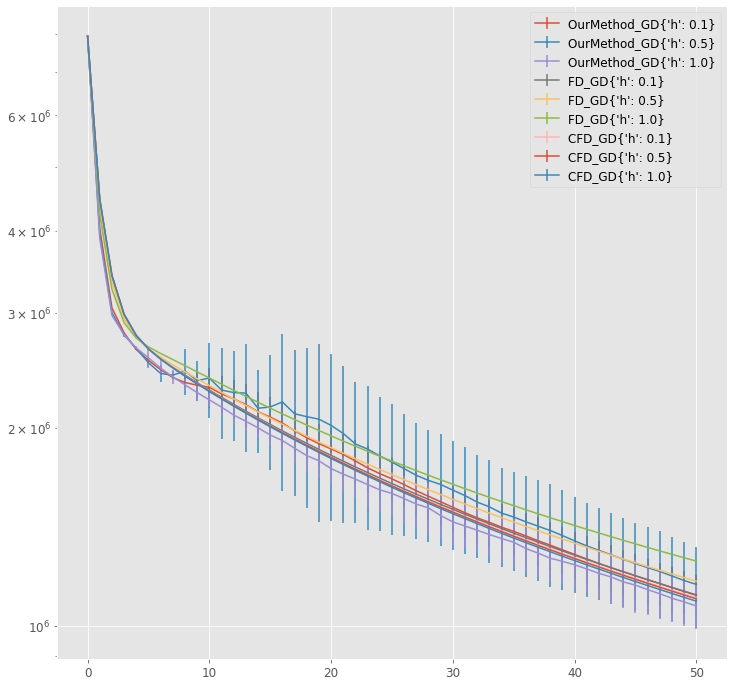

 10%|█         | 15/145 [00:21<03:04,  1.42s/it]

CLIFF_2


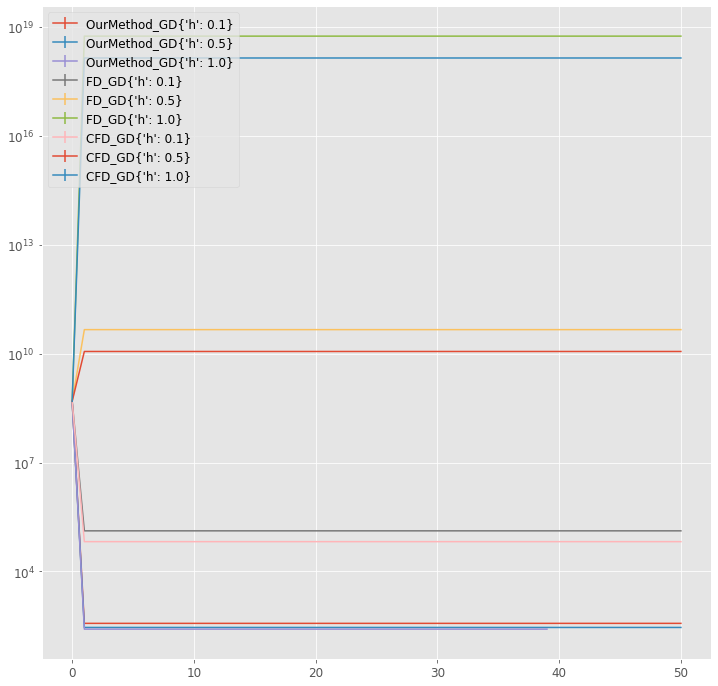

 11%|█         | 16/145 [00:22<02:49,  1.31s/it]

CRAGGLVY_10


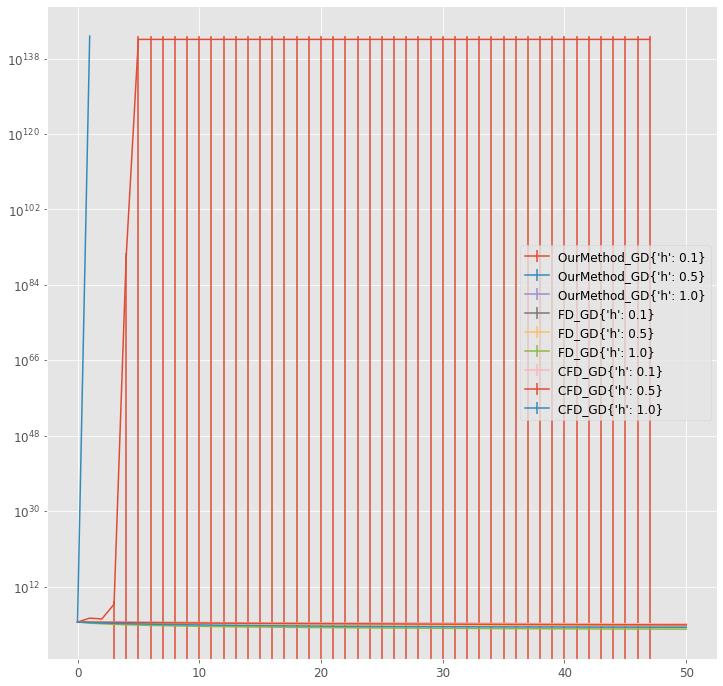

 12%|█▏        | 17/145 [00:35<10:18,  4.83s/it]

CRAGGLVY_100


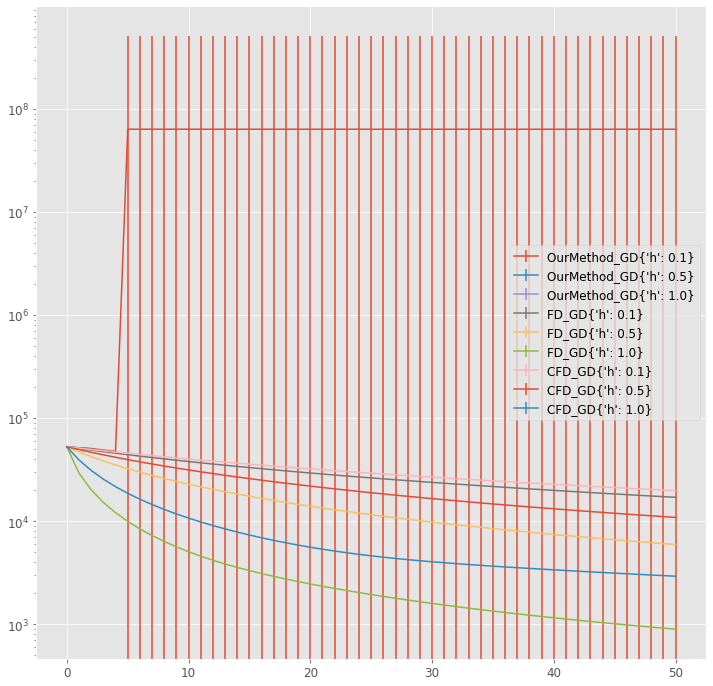

 12%|█▏        | 18/145 [00:40<10:20,  4.88s/it]

CRAGGLVY_4


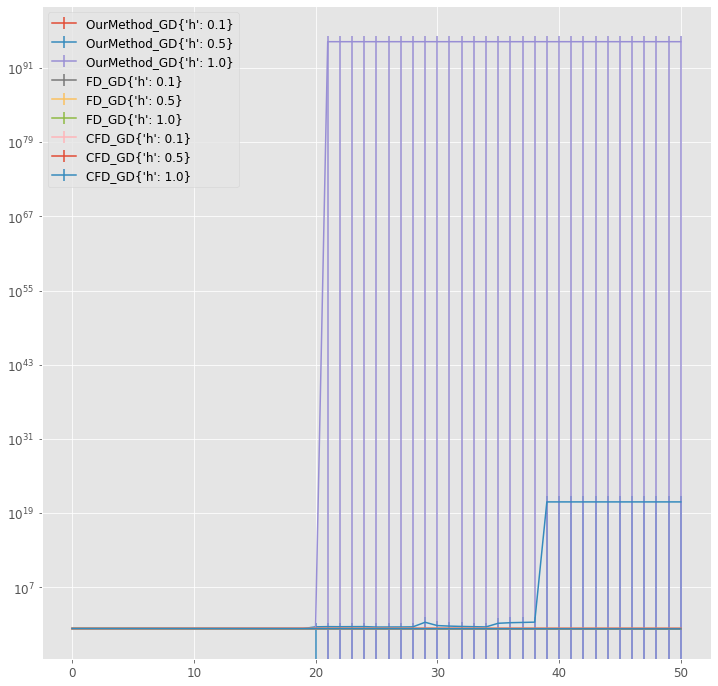

 13%|█▎        | 19/145 [00:42<08:15,  3.93s/it]

CRAGGLVY_50


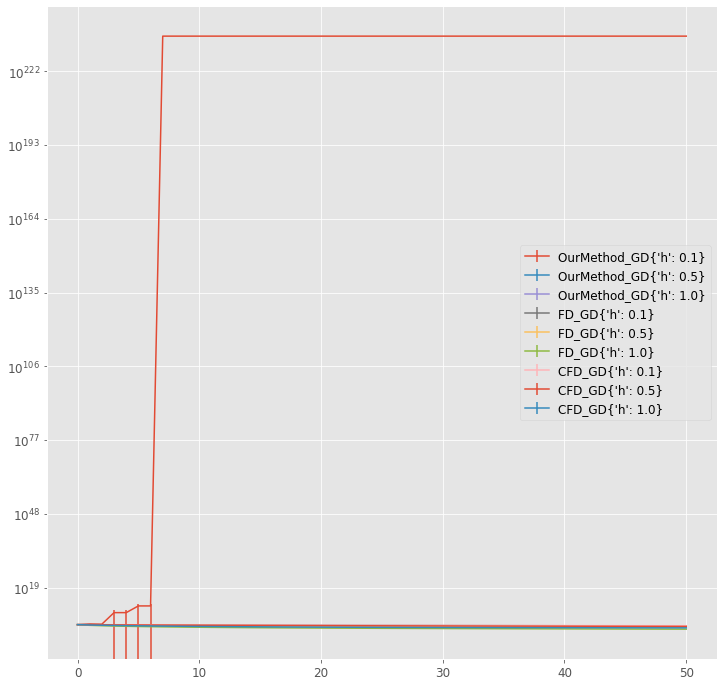

 14%|█▍        | 20/145 [00:50<11:09,  5.36s/it]

CUBE_2


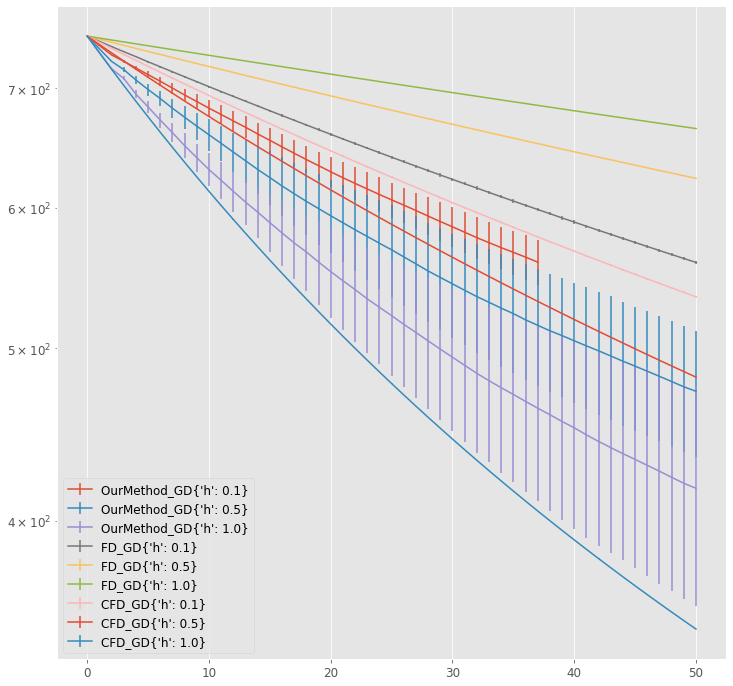

 14%|█▍        | 21/145 [00:52<08:26,  4.08s/it]

DENSCHNA_2


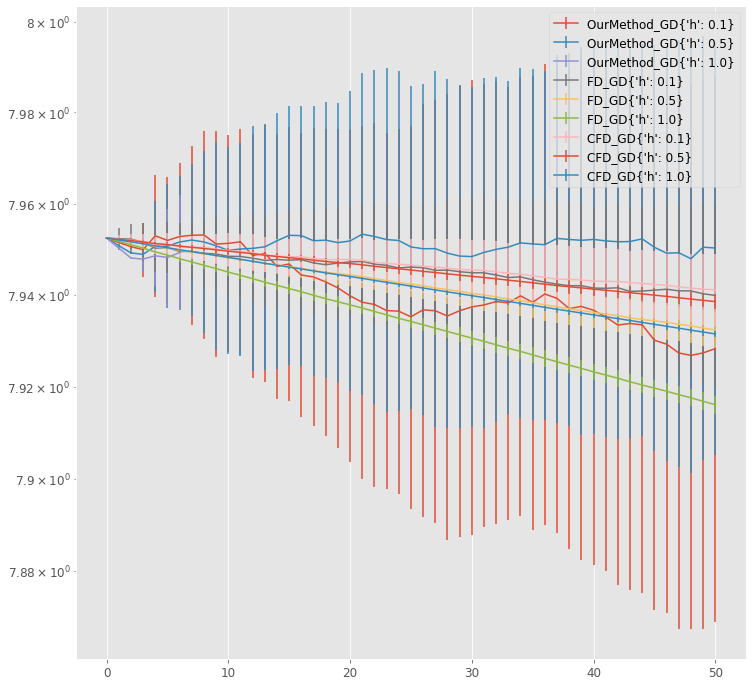

 15%|█▌        | 22/145 [00:53<06:35,  3.22s/it]

DENSCHNB_2


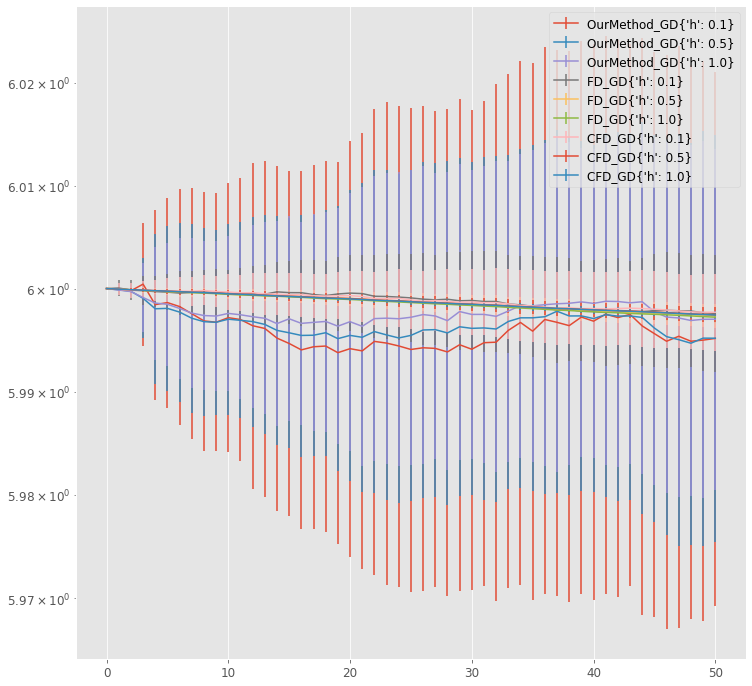

 16%|█▌        | 23/145 [00:54<05:21,  2.63s/it]

DENSCHNC_2


 16%|█▌        | 23/145 [00:56<04:57,  2.44s/it]

KeyboardInterrupt



In [15]:
# Get min 
res = {}

hp_s_mult = {
    "OurMethod_GD": {"h": [0.1, 0.5, 1.0]},
    "FD_GD": {"h": [0.1, 0.5, 1.0]},
    "CFD_GD": {"h": [0.1, 0.5, 1.0]}
}


def get_avgs(opt_type, F_name, hp, add_info):
    xs = [] 
    ys = []
    
    if opt_type in ["GradientDescent", "NewtonsMethod"]:
        opt_res, _ = load_opt(opt_type, F_name, hp["sig"], hp["noise_type"], hp["step_size"], seed=None, additional_info=add_info)
        opt_res_all = {"0": opt_res}
    else:
        opt_res_all, _ = load_all_opt(opt_type, F_name, hp["sig"], hp["noise_type"], hp["step_size"], additional_info=add_info)
        
    
    if opt_res_all is None:
        print(F_name)
        print(hp)
        print(opt_type)

        return float('inf')
    
    for opt_res in opt_res_all.values():
        if len(opt_res.shape) == 1:
            ys.append(opt_res)
        else:
            ys.append(opt_res[:, 0])
        xs.append(jnp.array(range(len(opt_res))))

    
    if len(xs) == 0:
        return float('inf')

        
    xs_new, ys_mean, ys_std = series_average(ys, xs)

    
    return xs_new, ys_mean, ys_std
    

for F_name in tqdm(df.index.unique(0)):
    print(F_name)
#     try:
    for opt_type in ["OurMethod_GD", "FD_GD", "CFD_GD"]: # df.index.levels[1]:

        if opt_type not in res:
            res[opt_type] = []
        if opt_type not in df.loc[F_name].index.unique(0):
            res[opt_type].append(float("inf"))
            continue


        if opt_type in hp_s_mult:
            for curr_hp in itertools.product(*hp_s_mult[opt_type].values()):
                curr_hp_s = {list(hp_s_mult[opt_type].keys())[i]: curr_hp[i] for i in range(len(curr_hp))}

                add_info = curr_hp_s
                xs, ys_mean, ys_std = get_avgs(opt_type, F_name, hp, add_info)
                plt.errorbar(xs, ys_mean, yerr=ys_std, label=opt_type + str(add_info))
        else:
            add_info = {}
            xs, ys_mean, ys_std = get_avgs(opt_type, F_name, hp, add_info)
            plt.errorbar(xs, ys_mean, yerr=ys_std, label=opt_type + str(add_info))

#     except:
#         continue

        
    plt.legend()
    plt.yscale("log")
        
    plt.show()


            


0
AIRCRFTB
FD central len 21
our len 11


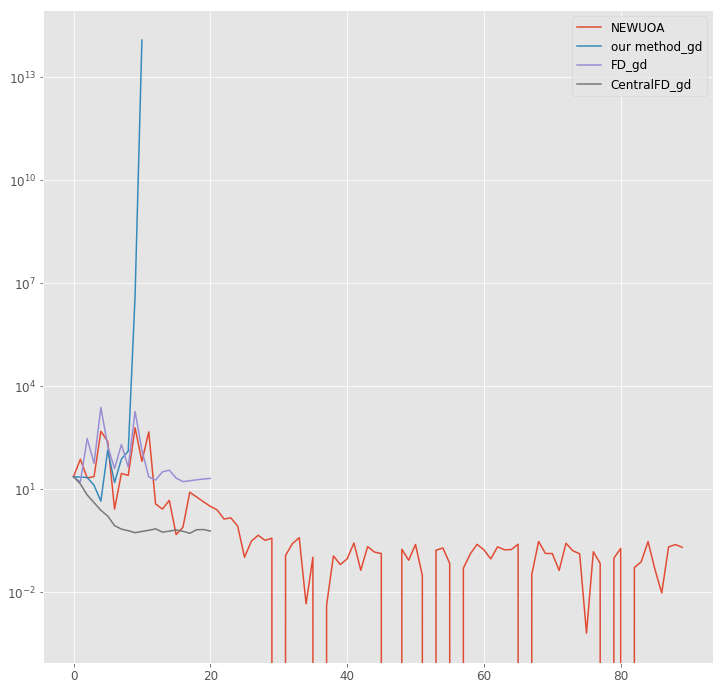

1
ALLINITU
FD central len 21
our len 21


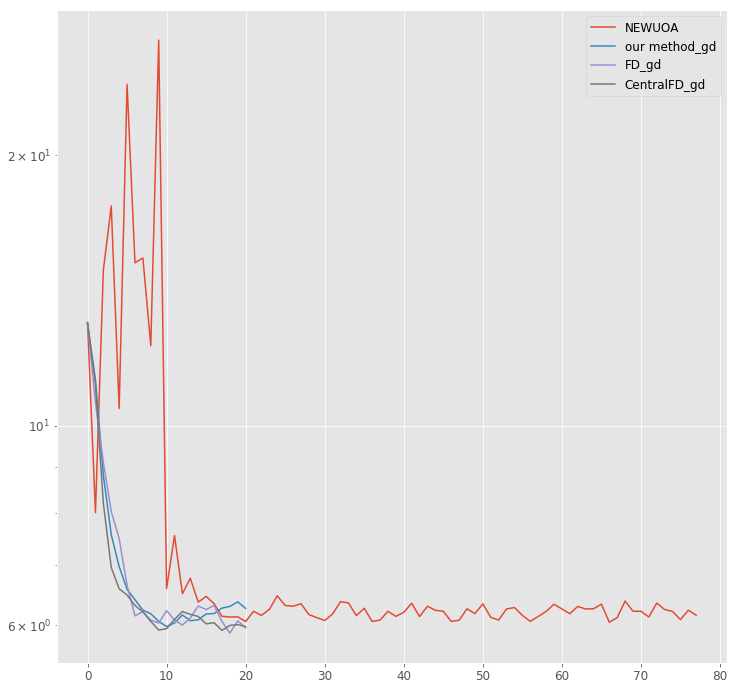

2
ARWHEAD
FD central len 21
our len 21


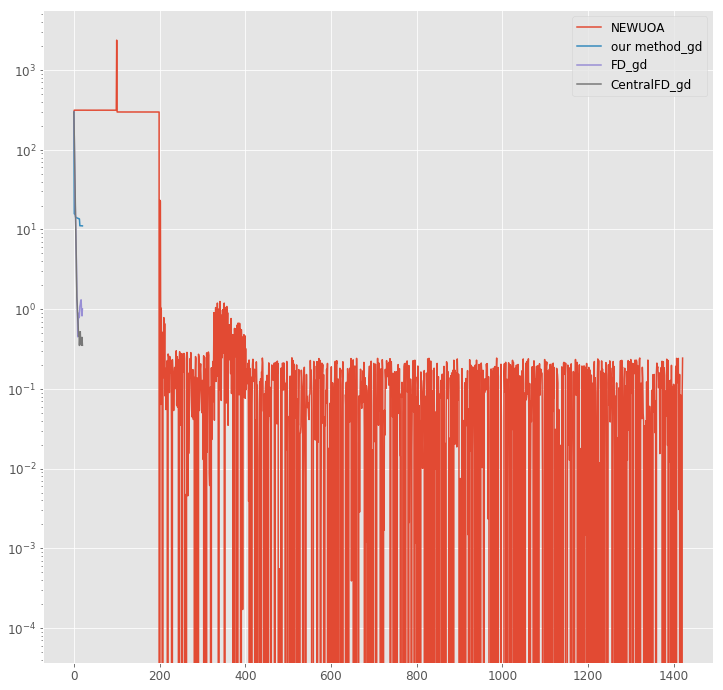

3
BARD
FD central len 21
our len 21


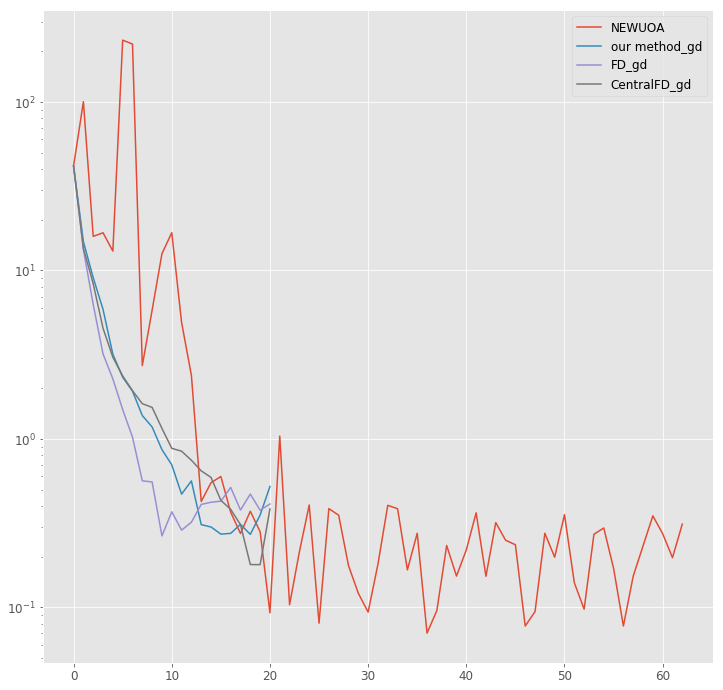

4
BDQRTIC
FD central len 21
our len 21


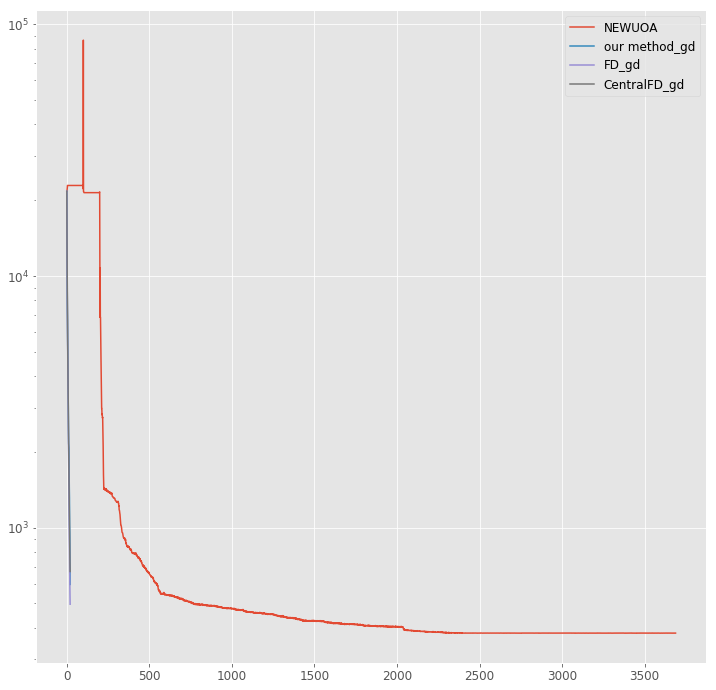

5
BIGGS3
FD central len 21
our len 21


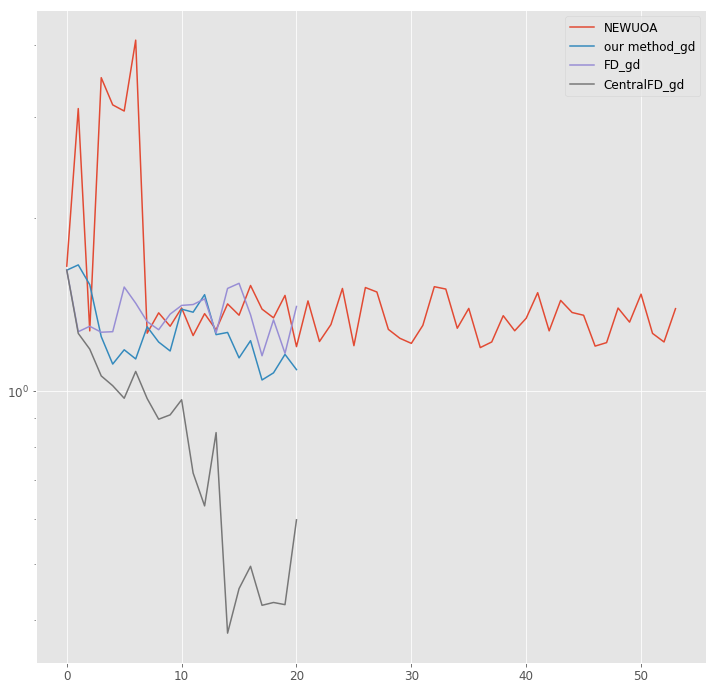

6
BIGGS5
FD central len 21
our len 21


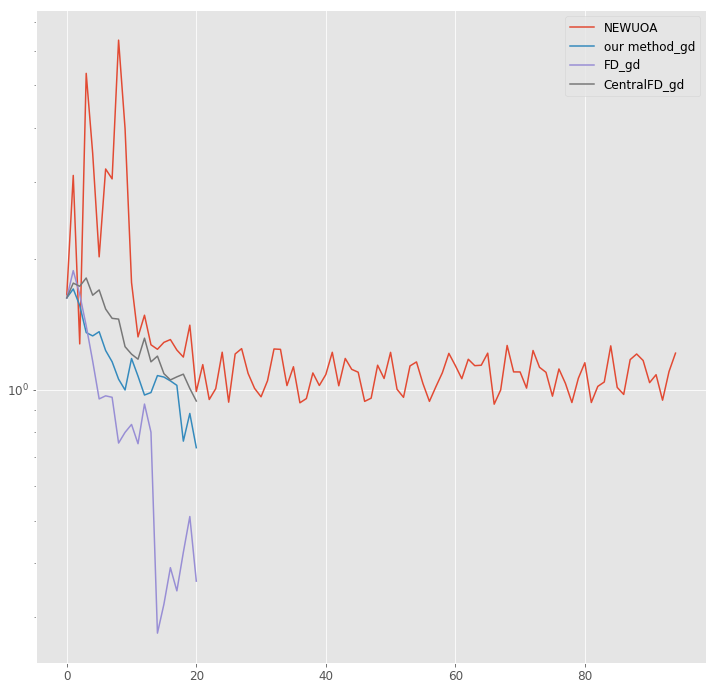

7
BIGGS6
FD central len 21
our len 21


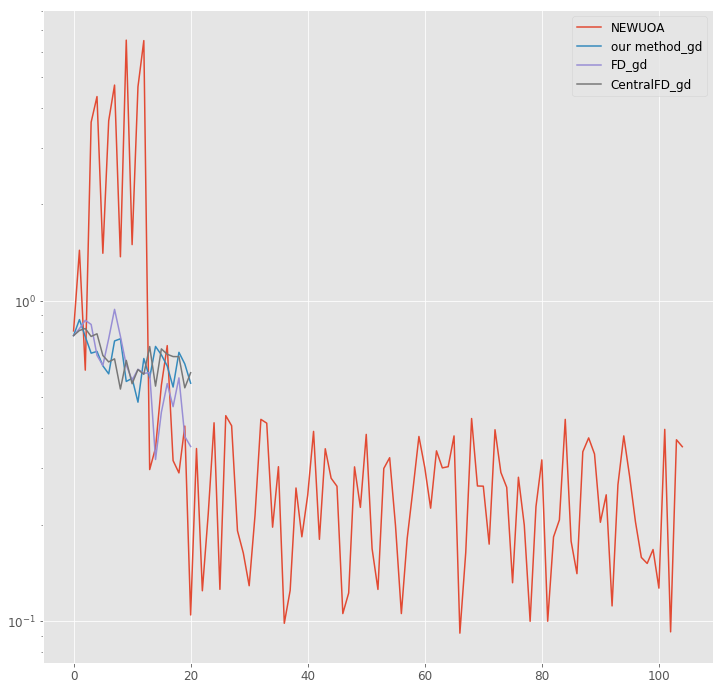

8
BOX2
FD central len 21
our len 21


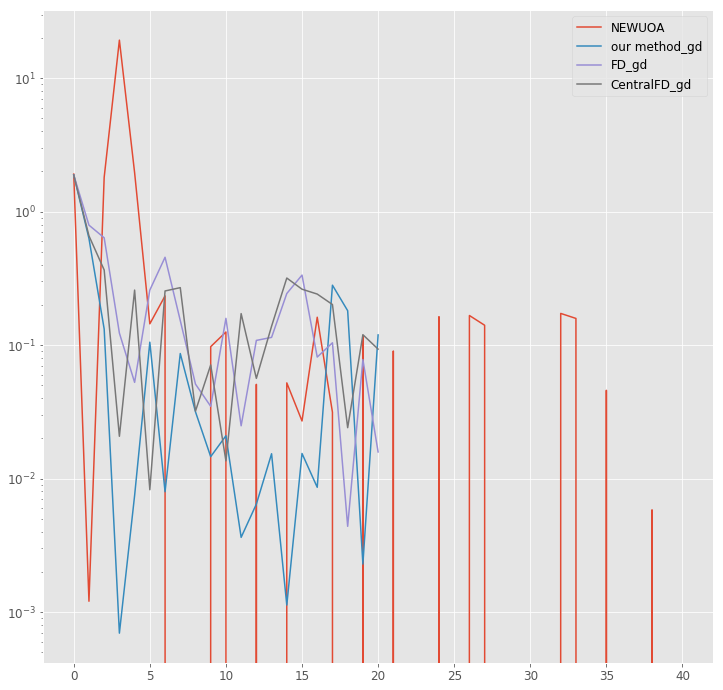

9
BOX3
FD central len 21
our len 21


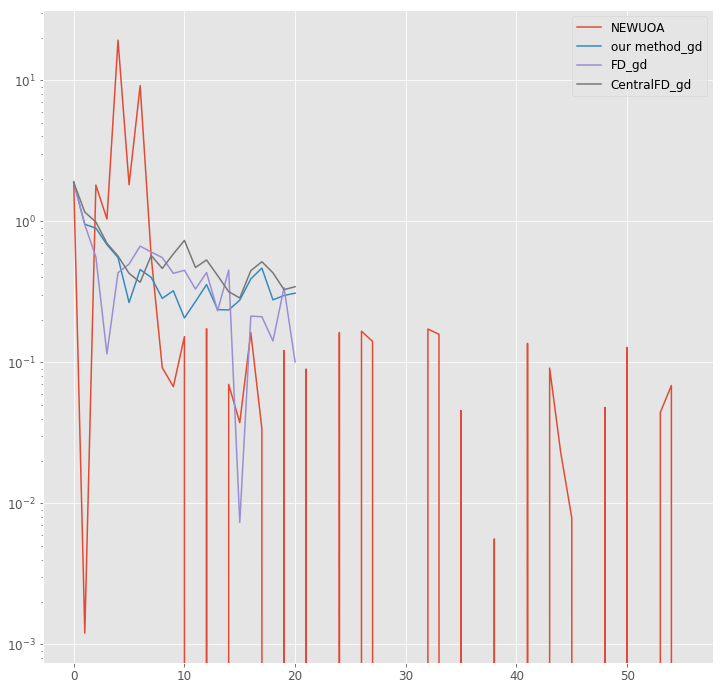

10
BRKMCC
FD central len 21
our len 21


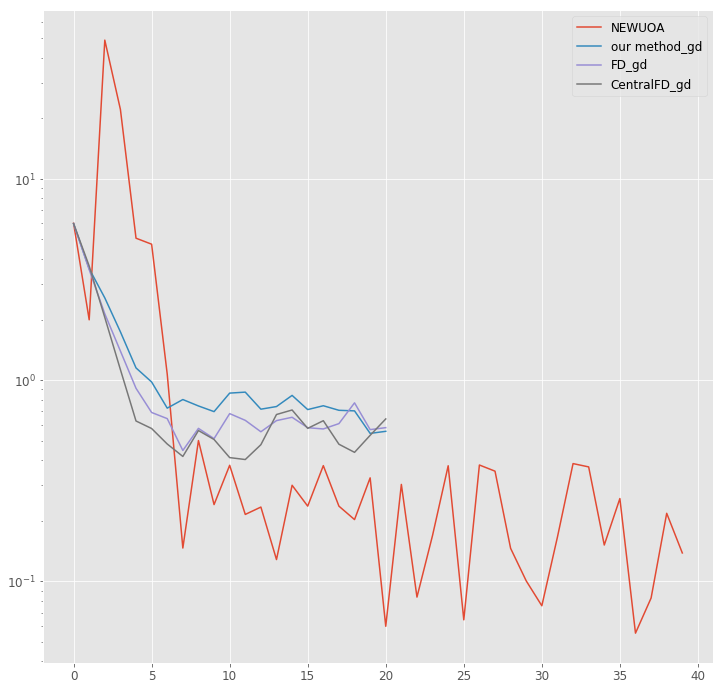

11
BROWNAL
FD central len 21
our len 21


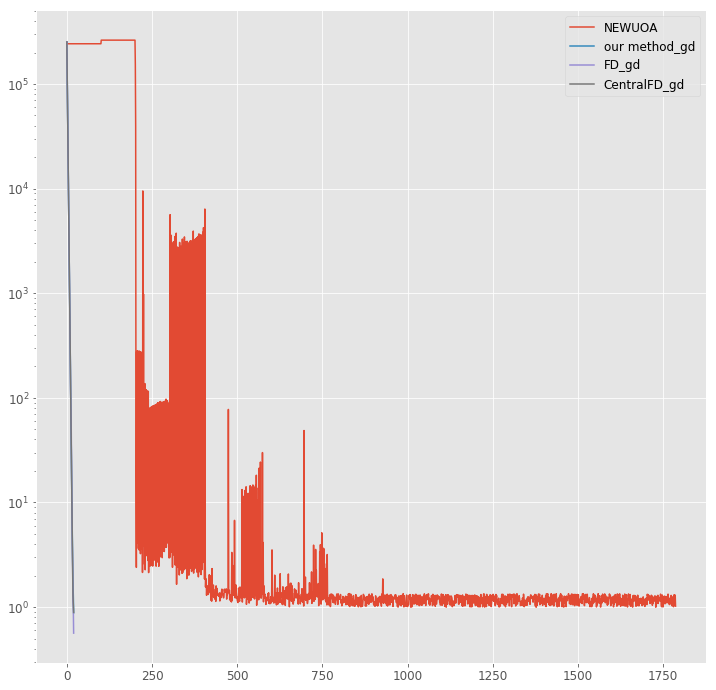

12
BROWNDEN
FD central len 4
our len 4


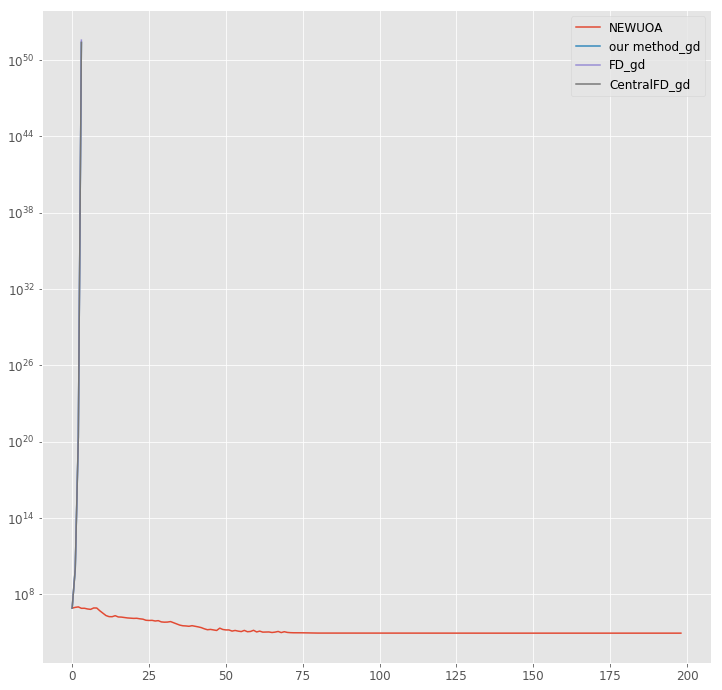

13
CLIFF
FD central len 21
our len 21


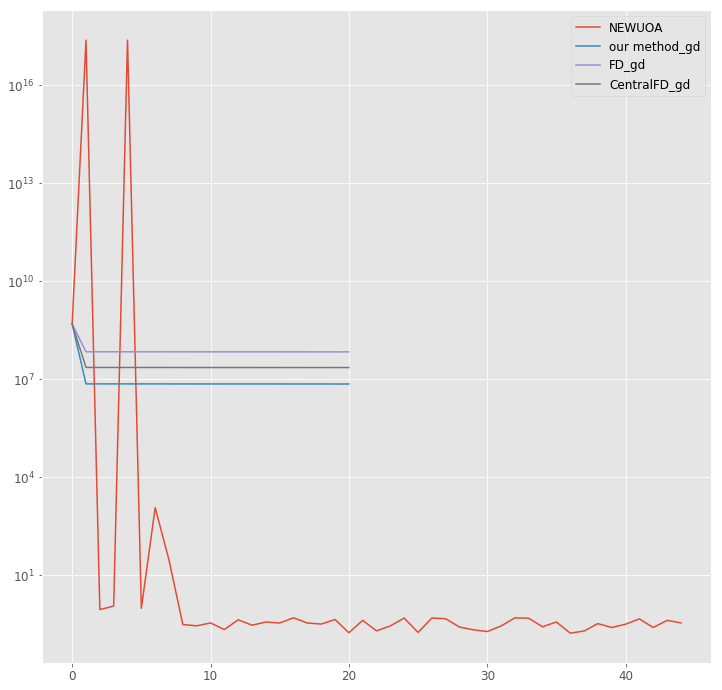

14
CRAGGLVY
Not found results for CRAGGLVY.
15
CUBE
FD central len 21
our len 21


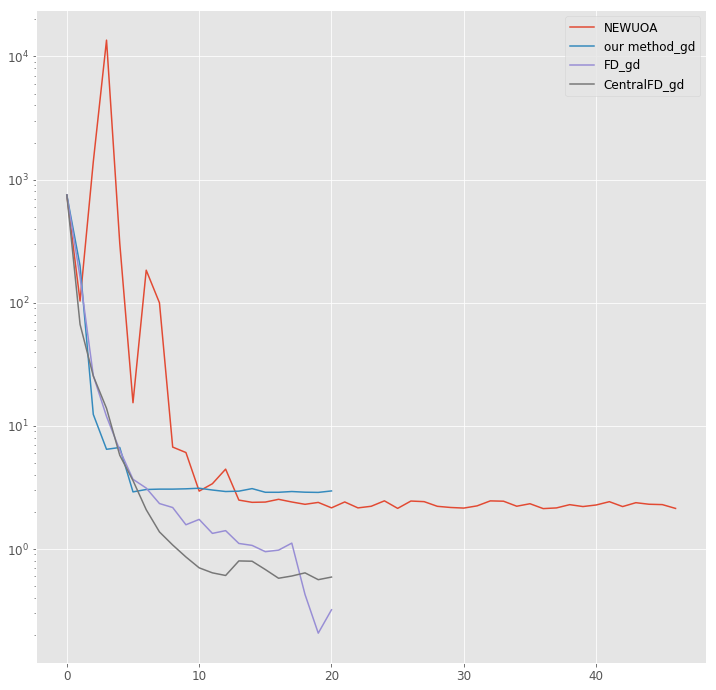

16
DENSCHND
FD central len 3
our len 2


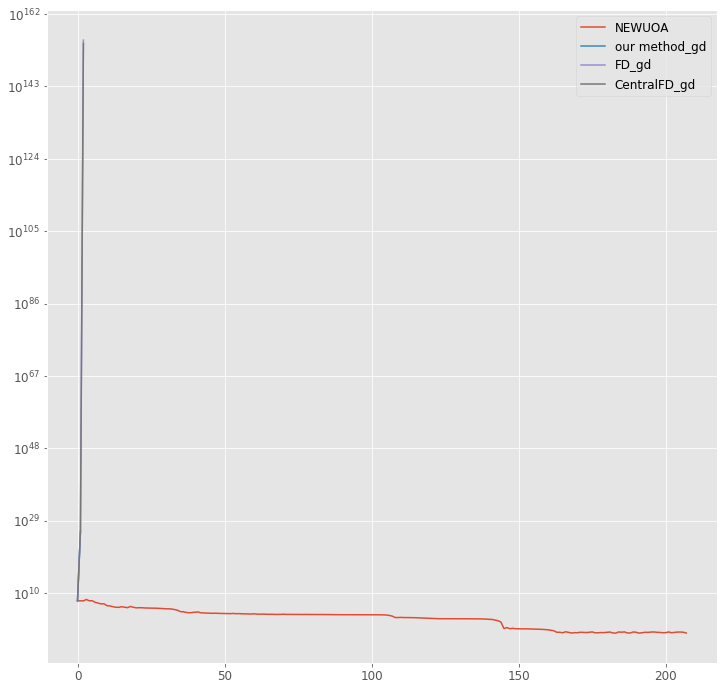

17
DENSCHNE
FD central len 21
our len 21


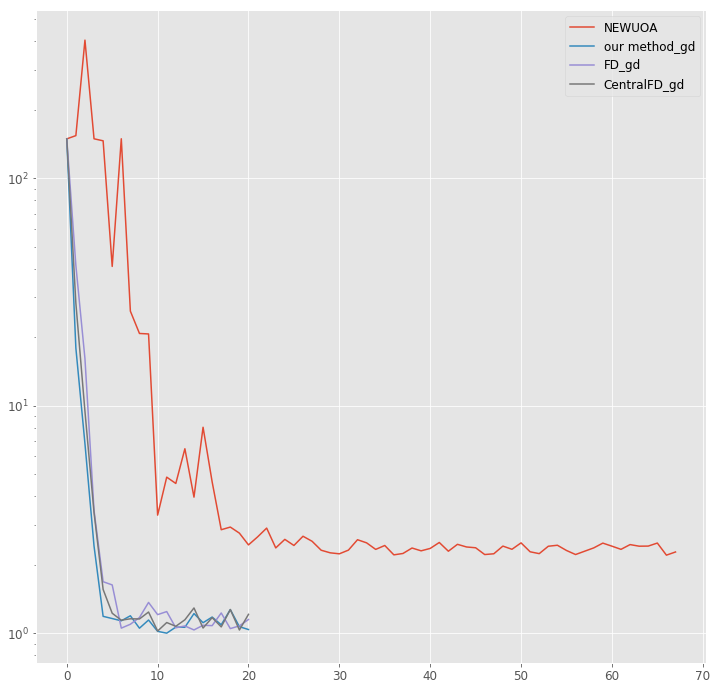

18
DIXMAANH
Not found results for DIXMAANH.
19
DQRTIC
FD central len 21
our len 21


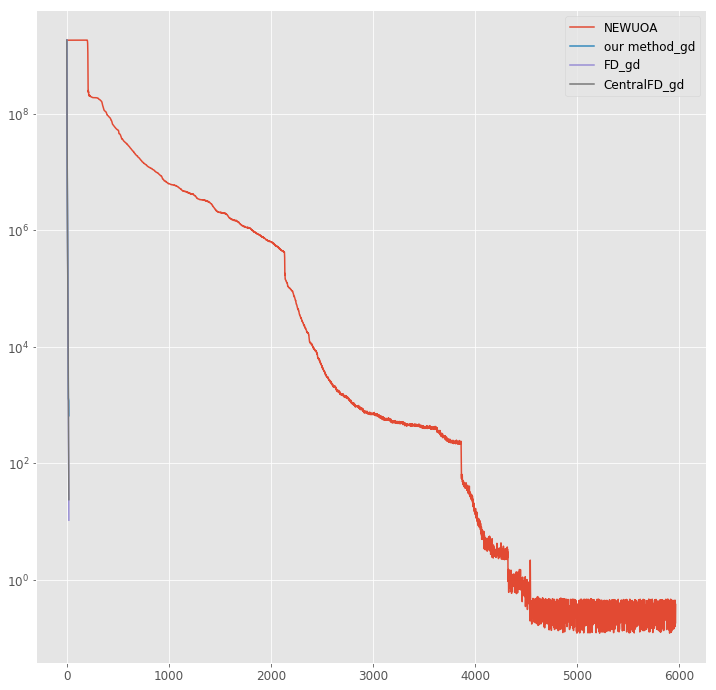

20
EDENSCH
FD central len 21
our len 21


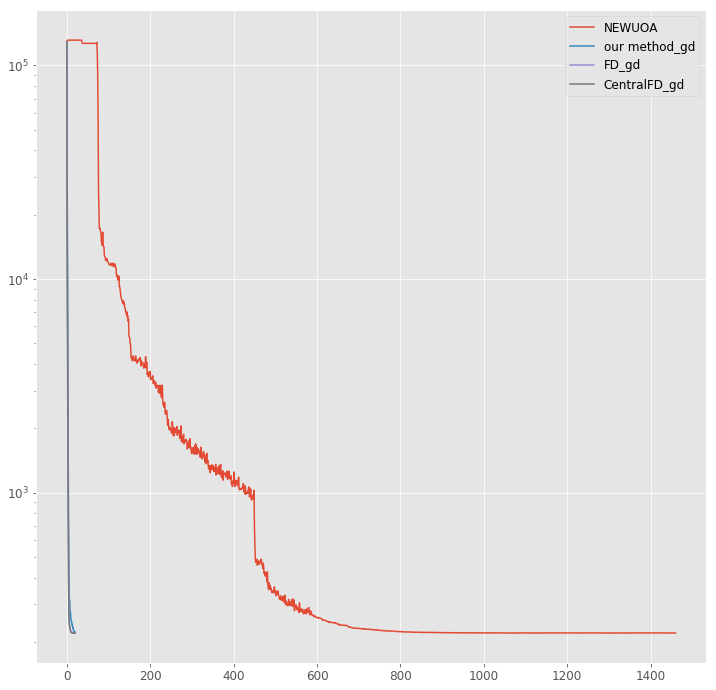

21
EIGENALS
Not found results for EIGENALS.
22
EIGENBLS
Not found results for EIGENBLS.
23
EIGENCLS
Not found results for EIGENCLS.
24
ENGVAL1
FD central len 21
our len 21


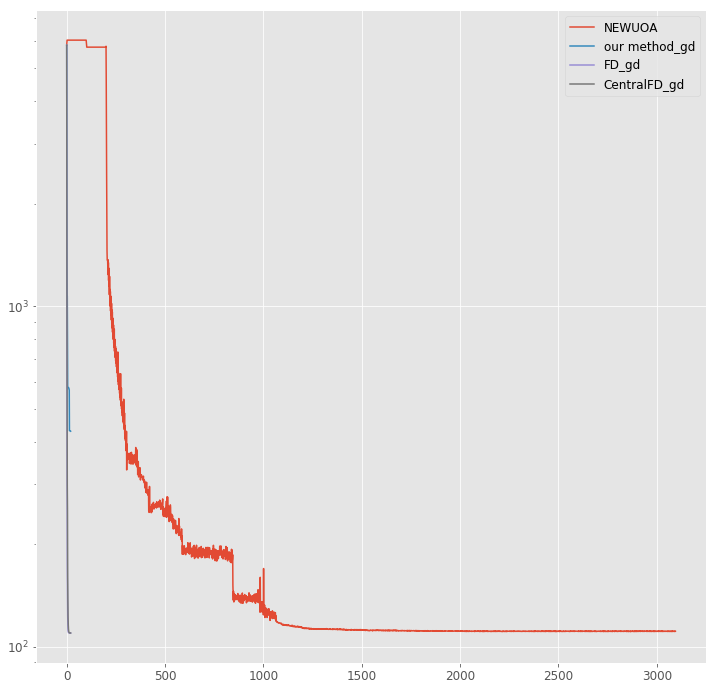

25
EXPFIT
FD central len 21
our len 21


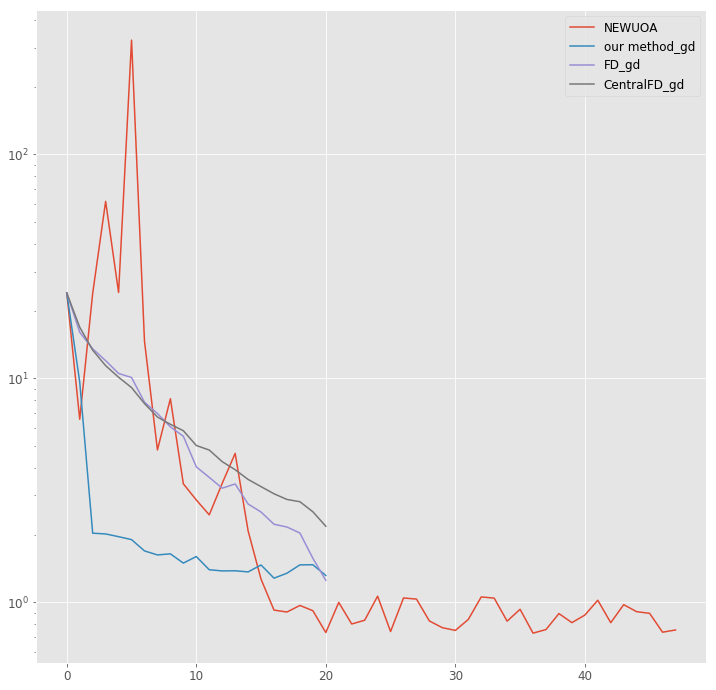

26
FLETCBV3
FD central len 21
our len 21


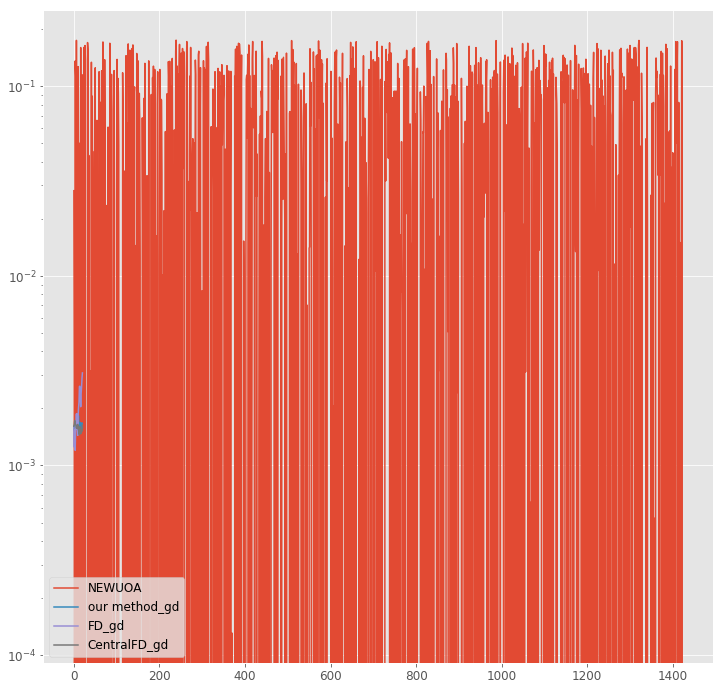

27
FLETCHBV
FD central len 21
our len 21


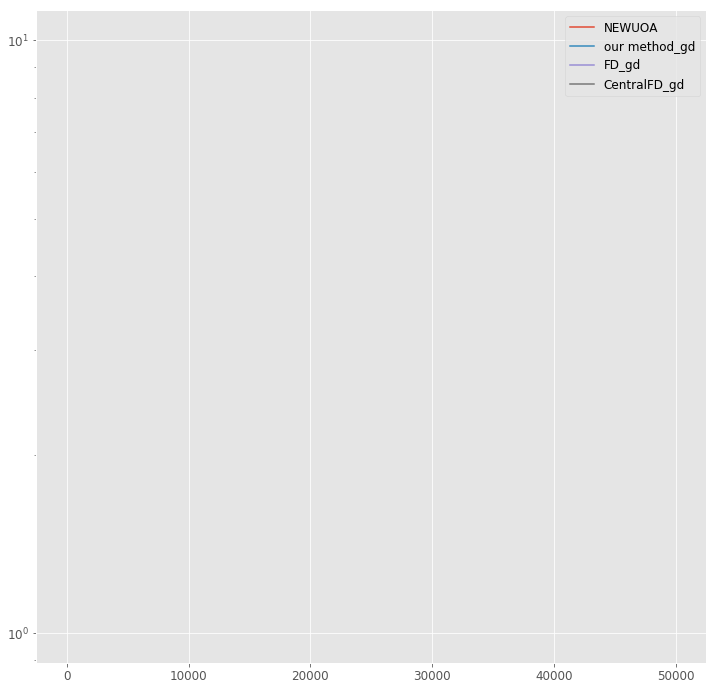

28
FREUROTH
FD central len 21
our len 21


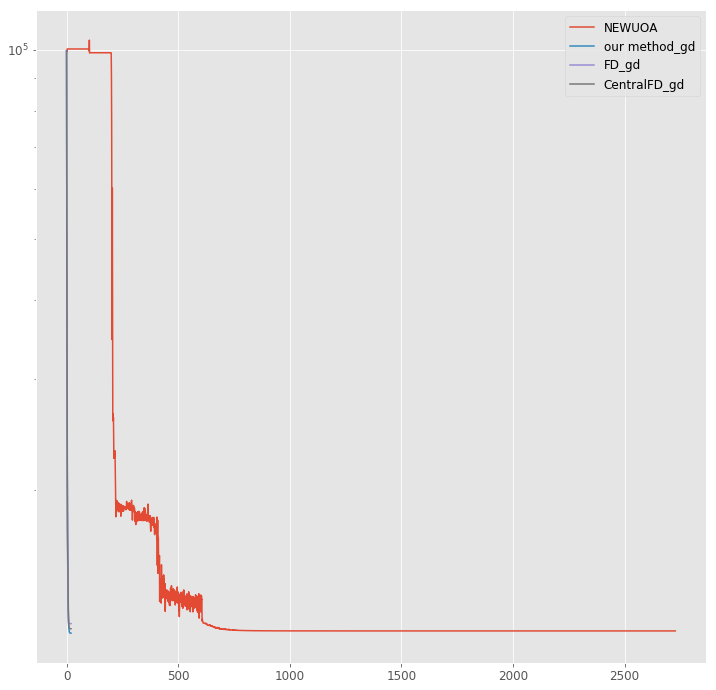

29
GENROSE
FD central len 21
our len 21


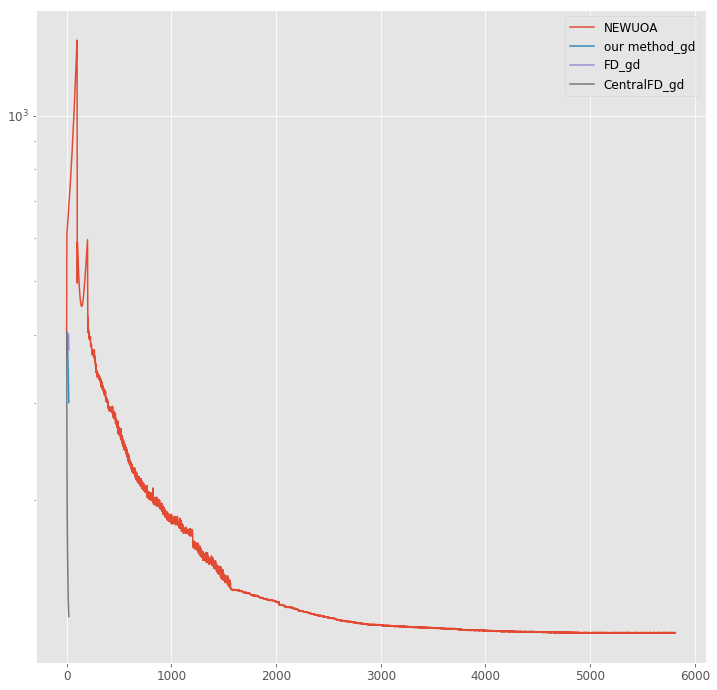

30
GULF
FD central len 21
our len 21


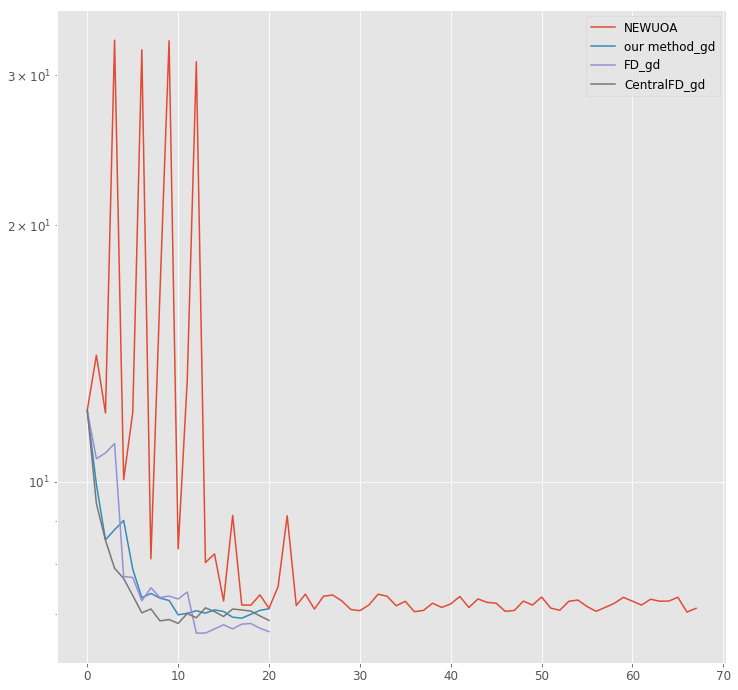

31
HAIRY
FD central len 21
our len 21


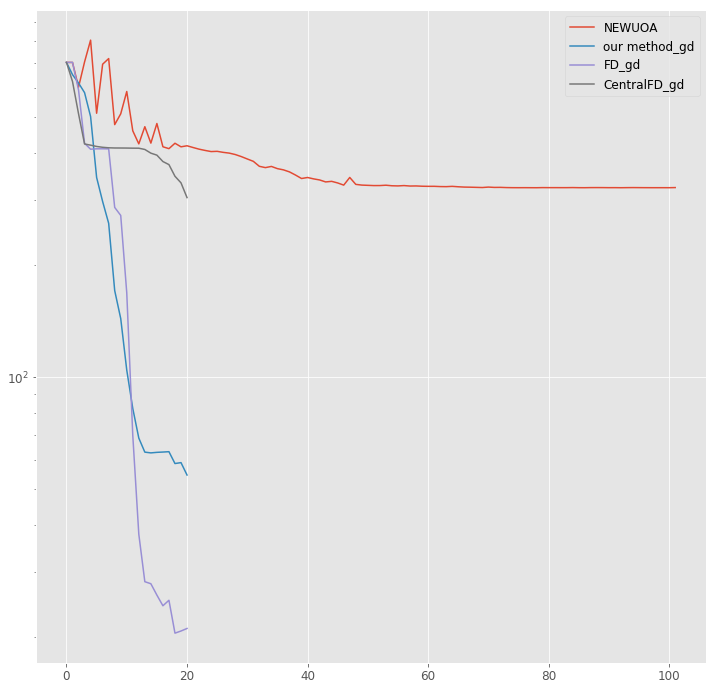

32
HELIX
FD central len 21
Not found results for HELIX.
33
NCB20B
FD central len 21
Not found results for NCB20B.
34
NONDIA
FD central len 21
Not found results for NONDIA.
35
NONDQUAR
FD central len 21
Not found results for NONDQUAR.
36
OSBORNEA
FD central len 21
Not found results for OSBORNEA.
37
OSBORNEB
FD central len 21
Not found results for OSBORNEB.
38
PENALTY1
FD central len 3
Not found results for PENALTY1.
39
PFIT1LS
FD central len 21
Not found results for PFIT1LS.
40
PFIT2LS
FD central len 21
Not found results for PFIT2LS.
41
PFIT3LS
FD central len 21
Not found results for PFIT3LS.
42
PFIT4LS
FD central len 21
Not found results for PFIT4LS.
43
QUARTC
FD central len 21
Not found results for QUARTC.
44
SINEVAL
FD central len 21
Not found results for SINEVAL.
45
SINQUAD
FD central len 21
Not found results for SINQUAD.
46
SISSER
FD central len 21
Not found results for SISSER.
47
SPARSQUR
FD central len 21
Not found results for SPARSQUR.
48
TOINTGSS
FD central len 21
Not found res

In [58]:
# eps = 0.1
noise_type = "uniform"
c1 = 0.1
c2 = 0.9
seed = 0
sig = 0.1


for i in range(len(adapt_functions)):
    test_problem_name = adapt_functions[i]

    try: 
        print(i)
        print(test_problem_name)
#         our_method = load_opt("OurMethod", test_problem_name, sig, noise_type, c1, c2, seed)
# #         adapt_fd = load_opt("AdaptFD", test_problem_name, sig, noise_type, c1, c2, seed)
        newuoa = load_opt("NEWUOA", test_problem_name, sig, noise_type, c1, c2, seed)
# #         newton_method = load_opt("NewtonExact", test_problem_name, sig, noise_type, c1, c2, seed)
#         fd = load_opt("FD", test_problem_name, sig, noise_type, c1, c2, seed)
#         central_fd = load_opt("CentralFD", test_problem_name, sig, noise_type, c1, c2, seed)

        our_method_gd = load_opt("OurMethod_GD", test_problem_name, sig, noise_type, c1, c2, seed)
        fd_gd = load_opt("FD_GD", test_problem_name, sig, noise_type, c1, c2, seed)
        central_fd_gd = load_opt("CentralFD_GD", test_problem_name, sig, noise_type, c1, c2, seed)



#         plt.plot(our_method[:, 2], our_method[:, 0], label="our method")
# #         plt.plot(adapt_fd[:, 2], adapt_fd[:, 0], label="AdaptFD")
#         plt.plot(newuoa, label="NEWUOA")
# #         plt.plot(newton_method[:, 2], newton_method[:, 0], label="NewtonExact")
#         plt.plot(fd[:, 2], fd[:, 0], label="FD")
#         plt.plot(central_fd[:, 2], central_fd[:, 0], label="CentralFD")

        print("FD central len", central_fd_gd.shape[0])
        print("our len", our_method_gd.shape[0])


        plt.plot(newuoa, label="NEWUOA")


        plt.plot(range(len(our_method_gd[:, 2])), our_method_gd[:, 0], label="our method_gd")
        plt.plot(range(len(fd_gd[:, 2])), fd_gd[:, 0], label="FD_gd")
        plt.plot(range(len(central_fd_gd[:, 2])), central_fd_gd[:, 0], label="CentralFD_gd")

#         plt.plot(our_method_gd[:, 2], our_method_gd[:, -1], label="our method_gd")
#         plt.plot(fd_gd[:, 2], fd_gd[:, -1], label="FD_gd")
#         plt.plot(central_fd_gd[:, 2], central_fd_gd[:, -1], label="CentralFD_gd")

        plt.yscale("log")
        plt.legend()
        plt.show()

    

    except:
        print("Not found results for {}.".format(test_problem_name))
    